In [ ]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt

# ========== PARAMETERS ==========
ALPHA = 0.05
MAX_ITER = 100
MAX_ITER_NI = 50
MAX_HUBS = 10  # You can adjust this based on your problem or try several values

# ========== DATA LOADING ==========
def load_large_instance_json(filename: str):
    with open(filename, "r") as f:
        data = json.load(f)
    return {
        'node_num': int(data["NodeNum"]),
        'flow': np.array(data["flow(wij)"]),
        'varcost': np.array(data["varCost(cij)"]),
        'fixcost': np.array(data["fixCost(fk)"]),
        'cap': np.array(data["Cap(ckmax)"]),
        'alpha': float(data["alpha"]),
        'total_flow': np.array(data["flow(wij)"]).sum()
    }

# ========== ASSIGNMENT FUNCTION ==========
def assign_nodes_to_hubs(hubs, data):
    node_num = data['node_num']              # Total number of nodes in the network
    cap = data['cap'].copy()                 # Copy of the hub capacity vector to track remaining capacity
    assignments = [-1] * node_num            # Initialize each node's assignment to -1 (unassigned)
    hub_flows = np.zeros(node_num)           # Track total flow assigned to each hub

    for i in range(node_num):
        best_hub = None                      # Best hub for node i (to be determined)
        best_cost = float('inf')             # Initialize best cost with infinity

        for h in hubs:
            # Compute total flow associated with node i (incoming + outgoing)
            flow = data['flow'][i, :].sum() + data['flow'][:, i].sum()

            # Check if assigning this flow to hub h exceeds its capacity
            if hub_flows[h] + flow > cap[h]:
                continue                     # Skip hub h if it can't handle the flow

            cost = data['varcost'][i, h]     # Variable cost of assigning node i to hub h

            # Update best hub if a lower-cost feasible option is found
            if cost < best_cost:
                best_cost = cost
                best_hub = h

        # Assign node i to the best feasible hub found
        if best_hub is not None:
            assignments[i] = best_hub
            hub_flows[best_hub] += flow      # Update flow usage for the selected hub
        else:
            # No feasible hub could accommodate this node's flow
            return None, None

    return assignments, hub_flows            # Return final node-to-hub assignments and hub load


# ========== COST FUNCTION ==========
def compute_total_cost(hubs, assignments, data):
    node_num = data['node_num']
    total_cost = sum(data['fixcost'][h] for h in hubs)
    # Spoke-to-hub and hub-to-spoke costs
    for i in range(node_num):
        h = assignments[i]
        total_cost += data['varcost'][i, h] * data['flow'][i, :].sum()
        total_cost += data['varcost'][h, i] * data['flow'][:, i].sum()
    # Hub-to-hub costs
    for i in range(node_num):
        for j in range(node_num):
            if i != j and assignments[i] != assignments[j]:
                total_cost += data['alpha'] * data['varcost'][assignments[i], assignments[j]] * data['flow'][i, j]
    return total_cost

# ========== INITIAL SOLUTION ==========
def generate_initial_solution(data, max_hubs=MAX_HUBS):
    node_num = data['node_num']
    # Generate candidate hub sets and keep the best feasible solution (based on total cost)
    best_hubs, best_assignments, best_cost = None, None, float('inf')
    for _ in range(100):
        hubs = sorted(random.sample(range(node_num), max_hubs))  # Select a random set of hubs
        assignments, hub_flows = assign_nodes_to_hubs(hubs, data)  # Ensure single allocation & capacity constraint (Constraints 1 & 8)
        if assignments is not None:
            cost = compute_total_cost(hubs, assignments, data)  # Objective function evaluation
            if cost < best_cost:
                best_hubs, best_assignments, best_cost = hubs, assignments, cost
    if best_hubs is None:
        raise RuntimeError("Failed to generate feasible initial solution")  # No solution met capacity limits
    return best_hubs, best_assignments, best_cost


# ========== LOCAL SEARCH ==========
def local_search(hubs, assignments, cost, data):
    node_num = data['node_num']
    best_hubs, best_assignments, best_cost = hubs[:], assignments[:], cost
    improved = True
    while improved:
        improved = False
        # Explore neighbors by replacing one hub with a non-hub node (modifying Z_kk)
        for h_out in best_hubs:
            for h_in in set(range(node_num)) - set(best_hubs):
                new_hubs = [h if h != h_out else h_in for h in best_hubs]
                new_hubs = sorted(new_hubs)
                # Reassign spokes under new hub configuration (respecting Constraints 1 and 8)
                new_assignments, _ = assign_nodes_to_hubs(new_hubs, data)
                if new_assignments is not None:
                    # Evaluate total cost (objective function)
                    new_cost = compute_total_cost(new_hubs, new_assignments, data)
                    if new_cost < best_cost:
                        best_hubs, best_assignments, best_cost = new_hubs, new_assignments, new_cost
                        improved = True
                        break
            if improved:
                break
    return best_hubs, best_assignments, best_cost

# ========== ILS MAIN LOOP ==========
def ils_algorithm(data, max_hubs=MAX_HUBS):
    # Generate initial solution satisfying Z_ik and Cmax_k (Constraints 1 and 8)
    best_hubs, best_assignments, best_cost = generate_initial_solution(data, max_hubs)
    print(f"Initial solution: cost = {best_cost:.2f}, hubs = {best_hubs}")

    # Local optimization to minimize objective function (Total Cost)
    best_hubs, best_assignments, best_cost = local_search(best_hubs, best_assignments, best_cost, data)
    print(f"After local search: cost = {best_cost:.2f}, hubs = {best_hubs}")

    no_improve = 0
    for it in range(MAX_ITER):
        # Perturbation: explore new hub configurations by modifying Z_kk
        h_out = random.choice(best_hubs)
        h_in = random.choice(list(set(range(data['node_num'])) - set(best_hubs)))
        new_hubs = [h if h != h_out else h_in for h in best_hubs]
        new_hubs = sorted(new_hubs)

        # Check feasibility under constraints (1) and (8)
        new_assignments, _ = assign_nodes_to_hubs(new_hubs, data)
        if new_assignments is not None:
            # Evaluate and improve using local search (minimize total cost)
            new_cost = compute_total_cost(new_hubs, new_assignments, data)
            new_hubs, new_assignments, new_cost = local_search(new_hubs, new_assignments, new_cost, data)

            # Accept solution if it improves or is close within ALPHA margin
            if new_cost < best_cost * (1 + ALPHA):
                if new_cost < best_cost:
                    print(f"Iter {it}: New best cost = {new_cost:.2f}, hubs = {new_hubs}")
                    best_hubs, best_assignments, best_cost = new_hubs, new_assignments, new_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1
        else:
            no_improve += 1

        # Stop if no improvement in consecutive iterations
        if no_improve >= MAX_ITER_NI:
            break

    return best_hubs, best_assignments, best_cost


if __name__ == "__main__":
    data = load_large_instance_json("InputDataHubLargeInstance.json")
    print(f"Problem with {data['node_num']} nodes and total flow {data['total_flow']}")
    for hubs_to_try in range(3, data['node_num'] + 1):
        try:
            print(f"Trying with {hubs_to_try} hubs...")
            best_hubs, best_assignments, best_cost = ils_algorithm(data, max_hubs=hubs_to_try)
            print("\n=== Final Solution ===")
            print(f"Hubs: {best_hubs}")
            print(f"Total cost: {best_cost:.2f}")
            print(f"Assignments: {best_assignments}")
            break
        except RuntimeError:
            continue

Problem with 30 nodes and total flow 2761970.0
Trying with 3 hubs...
Trying with 4 hubs...
Trying with 5 hubs...
Trying with 6 hubs...
Trying with 7 hubs...
Trying with 8 hubs...
Trying with 9 hubs...
Trying with 10 hubs...
Trying with 11 hubs...
Trying with 12 hubs...
Trying with 13 hubs...
Trying with 14 hubs...
Initial solution: cost = 137968528.30, hubs = [1, 2, 3, 6, 10, 12, 15, 18, 19, 20, 21, 22, 23, 24]
After local search: cost = 124041592.30, hubs = [1, 3, 6, 9, 11, 14, 15, 18, 19, 20, 23, 24, 26, 28]
Iter 1: New best cost = 123990073.70, hubs = [1, 3, 6, 9, 14, 15, 16, 18, 19, 23, 24, 25, 26, 28]

=== Final Solution ===
Hubs: [1, 3, 6, 9, 14, 15, 16, 18, 19, 23, 24, 25, 26, 28]
Total cost: 123990073.70
Assignments: [24, 1, 3, 3, 28, 18, 6, 23, 1, 9, 15, 25, 16, 3, 14, 15, 16, 19, 18, 19, 1, 9, 6, 23, 24, 25, 26, 14, 28, 23]


In [ ]:
def plot_hub_network(best_hubs, best_assignments, data):
    import networkx as nx
    node_num = data['node_num']
    G = nx.Graph()
    # Add all nodes
    for i in range(node_num):
        G.add_node(i)
    # Add edges: spoke to hub
    for i in range(node_num):
        if i not in best_hubs:
            G.add_edge(i, best_assignments[i])
    # Node colors: hubs red, others blue
    node_colors = ['red' if n in best_hubs else 'skyblue' for n in G.nodes()]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600, font_size=10, font_weight="bold", edge_color='gray')
    plt.title("Hub-and-Spoke Network (Hubs in Red)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

<ipython-input-16-10e9ea8ccf06>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


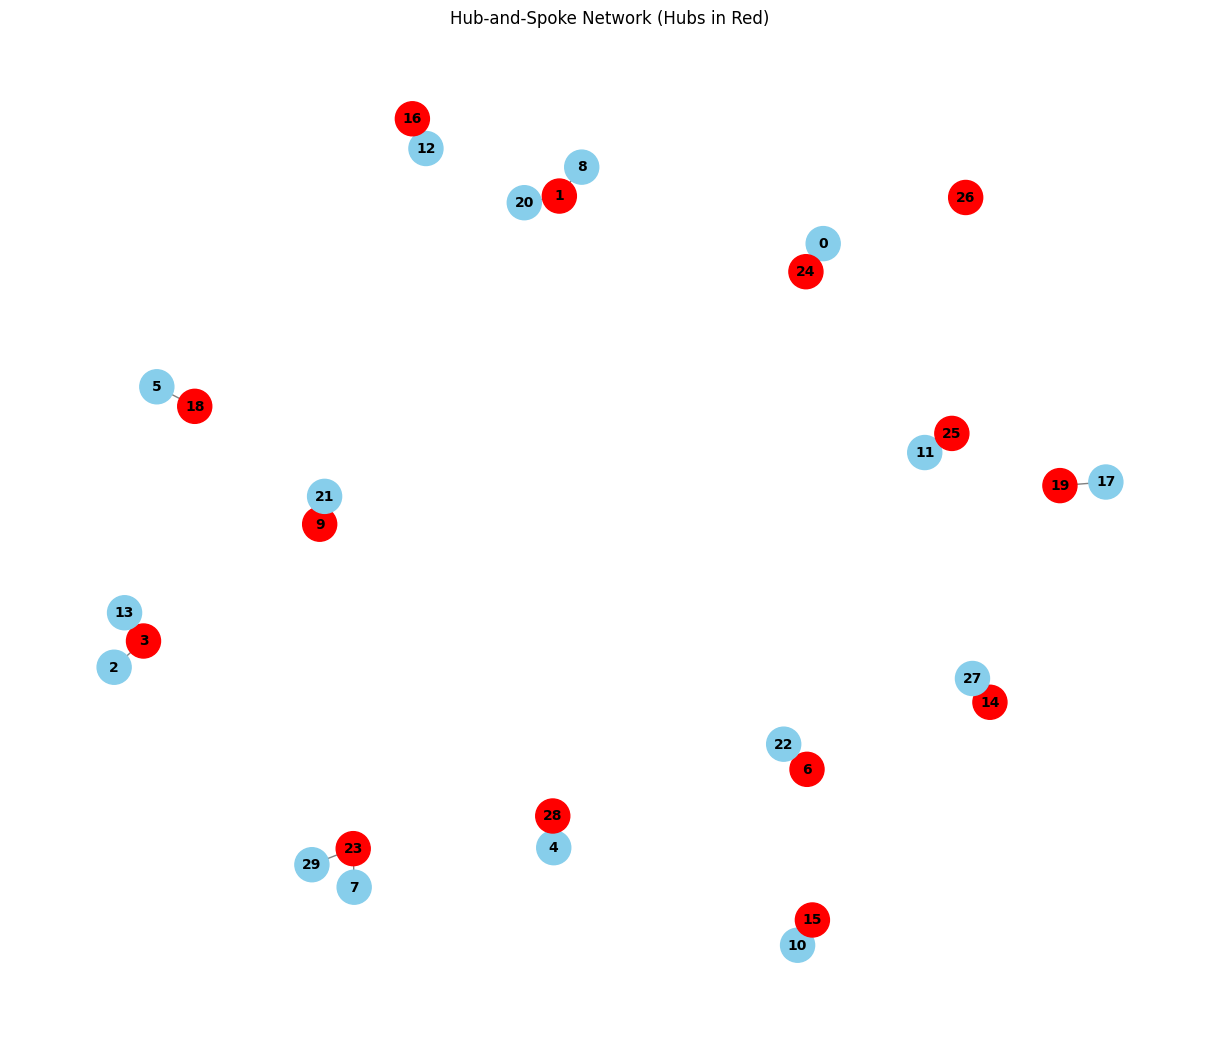

In [ ]:
plot_hub_network(best_hubs, best_assignments, data)